## Klasteryzacja
#### Czym jest klasteryzacja?
Najprościej -- szukaniem skupień (klastrów).
![](https://miro.medium.com/max/561/0*ff7kw5DRQbs_uixR.jpg)
Żródło: https://www.kdnuggets.com/2019/09/hierarchical-clustering.html

#### Po co?
* Aby znaleźć "naturalne" podziały w zbiorze.
* Aby zaproponować podział na klasy.
* Aby ułatwić opis (klastrom można przyporządkować etykiety i do pewnego stopnia traktować jako całość).
* ...

#### Czym właściwie jest klaster?
Nie mamy jednej definicji. Generalnie -- grupa podobnych objektów. Różne algorytmy rożnie "rozumieją" podobieństwo i różnie go szukają.

Zasadniczo metody dzielimy na metody hierarchiczne i niehierachiczne (TODO: jest lepsza nazwa?).
Zacznimy od niehierarchicznych.

### Metoda k-średnich
Pomysł jest prosty:
1. Zakładamy, że w zbiorze jest k klastrów.
2. Losujemy k punktów będącymi początkowymi położeniami środków naszych klastrów.
![](https://upload.wikimedia.org/wikipedia/commons/5/5e/K_Means_Example_Step_1.svg)
3. Określamy przynależność do klastrów jako przynależność do klastra "genrowanego" przez najbliższy środek.
![](https://upload.wikimedia.org/wikipedia/commons/a/a5/K_Means_Example_Step_2.svg)
4. Aktualizujemy położenie środków klastrów jako środek masy punków należących do klastra.
![](https://upload.wikimedia.org/wikipedia/commons/3/3e/K_Means_Example_Step_3.svg)
5. Sprawdzamy, czy przynależność jakiegkolwiek punktu zmieniła się po wyznaczeniu nowych środków. Jeśli tak -- wracmy do punktu 3. Jeśli nie -- kończymy działanie

Źródło ilustracji: https://en.wikipedia.org/wiki/K-means_clustering

Działanie algortymu wygląda następująco:
![](https://miro.medium.com/max/960/1*KrcZK0xYgTa4qFrVr0fO2w.gif)
Żródło: https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68

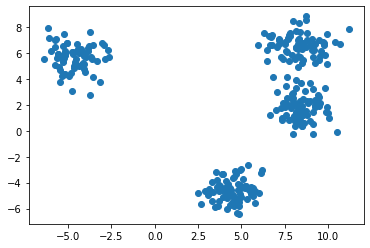

In [21]:
# Nareszcie kod!
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.9, random_state=314)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [22]:
from sklearn.cluster import KMeans

def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.show()

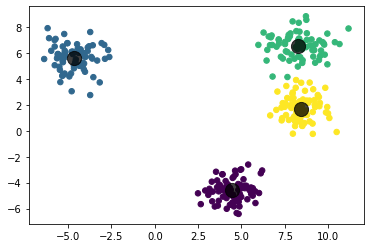

In [23]:
plot_kmeans_clusters(X, n_clusters=4)

TODO: Może fajnie byłoby obejżeć scieżki, po których zbiegają środki. A może to za duzo zabawy programistycznej.

#### A co jeśli podamy złe k?

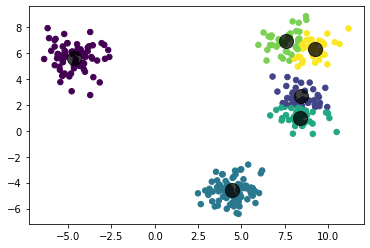

In [24]:
plot_kmeans_clusters(X, n_clusters=6)

### Zatem jak dobrać liczbę skupień?

#### Metoda łokcia
Zacznijmy od tego, że algortym k-średnich minimalizuję wewnątrzklastrową sumę kwadratów (ang. within-cluster sum of squares):

$$\underset{\mathbf{S}}{\operatorname{argmin}}\sum_{i=1}^{k}\sum_{\mathbf{x} \in S_i} {\lVert \mathbf{x} - \mu_i \rVert^2} = \underset{\mathbf{S}}{\operatorname{argmin}}\sum_{i=1}^{k} | S_i | \mathrm{Var} (S_i)
$$

Liczymy sumę odległości punktu od środka skupienia (możemy tutaj użyć różnych metryk, my zastosujemy kwadrat odległości $L_2$, ponieważ jest to naturalna metryka dla naszego algorytmu). Rysujemy wykres tejże odległości w zależności od liczby klastrów i wybieramy punkt "przegięcia". Wygląda on jak łokieć - stąd nazwa metody.

In [25]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

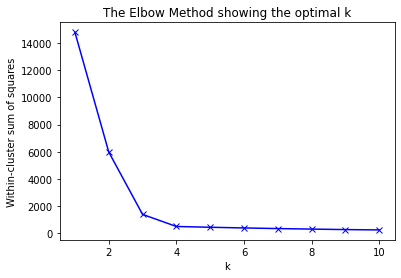

In [26]:
wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Oczywiście jest to metoda subiektywna i czasami wybór łokcia jest nieoczywisty. Dlatego często stosuje się inną metodę:

#### Metoda silhouette

Zdefiniujmy:
$$ a(i) := \frac{1}{| C(i) -1 |} \sum_{j \in C(i), i \neq j} d(i, j)$$
Gdzie:  
$i$ -- indeks punktu,  
$C(i)$ -- klaster, do którego należy $i$-ty punkt,  
$d(i, j)$ -- odległość między $i$-tym i $j$-tym punktem.

Liczbę $a$ możemy interpretować jako średnią odległość od punktu w tym samym klastrze.

$$ b(i) := \underset{k: C_k \bigcap C(i) = \emptyset}{min} \frac{1}{|C_k|} \sum_{j \in C_k} d(i, j) $$
$C_k$ to $k$-ty klaster. Nie mylić z oznaczeniem $C(i)$, czyli klastrem, do którego należy $i$-ty punkt.


Liczba $b$ to po prostu średnia odległość od punktów tego klastra, który jest "drugim najlepszym" dla $i$-tego punktu.  

Jeśli $|C(i)| \neq 1$ definiujemy:  
$$ s(i) := \frac{b(i) - a(i)}{\max{ \{ a(i), b(i) \} }} $$
Dla kompletności dodajmy, że jeśli $|C(i)| = 1$, wtedy:
$$ s(i) := 0 $$
Zatem $s(i)$ mówi nam o tym, jak dobrze dany punkt pasuje do klastra, do którego został przyporządkowany w porównaiu z tym klastrem, który jest "drugim wyborem".

Ostatecznie nasza miara silhouette to średnia $s(i)$ po wszystkich punktach:
$$ \frac{\sum_{i=1}^{n} s(i)}{n} $$
Oczywiście $n$ to liczba wszytkich punktów.

Największa wada? Premiowanie "okrągłych" klastrów.

In [84]:
# A w praktyce wygląda to tak:
def count_clustering_scores(X, cluster_num_seq, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie objektów typu callable: model i score_fun.
    scores = []
    for k in cluster_num_seq:
        kmeans = model(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    return scores

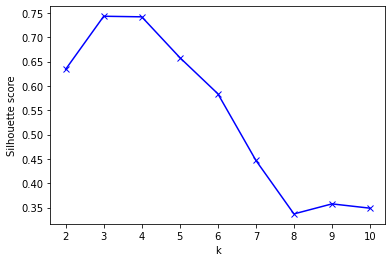

In [85]:
from sklearn.metrics import silhouette_score

cluster_num_seq = range(2, 11) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Inne, podobne metryki:  
Indeks Daviesa–Bouldina
<details>
<summary> Indeks Dunna (dla zaintesowanych -- kliknij!) </summary>
$$ DI = \frac{ \underset{i, j}{\min} \delta (C_i, C_j)}{\underset{k}{\min} \Delta (C_k)} $$

Gdzie:  
$\delta (C_i, C_j)$ -- odległość między klastrami. Możemy ją liczyć na wiele sposóbów. Są to między innymi:
* Średnia odległość między punktami obu klastrów.
* Najmniejsza odległość między punktami obu klastrów.
* Maksymalna odległość między punktami obu klastrów.
* Odległośc między środkami klastrów.

$\Delta (C_k)$ -- wielkość klastra. Znowu mamy wiele pomysłów na jej wyznaczanie:
* Maksymalna odległość między punktami.
* Średnia odległość między punktami.
* Dwukrotność średniej odległości do środka (można o tym myśleć jako o czymś na wzór średnicy).

Indeks Dunna "patrzy" tylko na największy klaster i najmniejszą odległość między klastrami. Czyli możemy myśleć o tym jako o rozważaniu najgorszego przypadku. Z drugiej strony jeśli odpowiednich $\delta ()$ i $ \Delta () $ --  do pewnego stopnia uniezależniamy się od premiowania "okrągłych" klastrów.
</details>
Indeks Calińskiego-Harabasza

### Metryki interpretowalne
Powyższe metryki dobrze sprawdzają się przy doborze liczby klastrów. Z drugiej strony są one trudne w interpretacji. Często mamy pewne oczekiwania wobec klastrów. Na przykład:
* Dobra separacja klastrów
* Małe odległości wewnątrz klastrów
* Klastry podobnej wielkości
* Dobra reprezentacja klastrów przez środki
* Stabliność klasteryzacji
* Duża gęstość klastrów

Często metrka, którą wybierzemy jest związana z tym, czego szukamy. Przykłady metryk:
* Dobra separacja klastrów -> minimalna odległośc między punktami rożnnych klastrów
* Małe odległości wewnątrz klastrów -> średnia odległość między punktami
* Klastry podobnej wielkości -> wariancja wielkości klastrów (na przykład średniej odległości między punktami)
* Dobra reprezentacja klastrów przez ich środki -> średnia odległość między punktem w klastrze a środkiem
* Stabliność klasteryzacji -> bootstrap i fracja punktów, które sie różnią
* Duża gęstość klastrów -> największa odległość między punktami wewnątrz klastra

Niestety metryki te są wrażliwe na liczbę klastrów. Na przykład jeśli naszym celem jest dobra reprezentacja punktów w klastrze przez środki, oczywiście najepiej będzie, gdy każdy punkt będzie osobnym klaststem. A to chyba nie o to chodziło. Dlatego tego typu metryki najlepiej sprawdzają się, gdy porównujemy różne algorytmy, ale przy ustalonej liczbie klastrów.

In [98]:
# Zaimplementujmy zatem.
from scipy.spatial import distance
import numpy as np

def two_class

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                #print(f'{X[cluster_i_idx]}, {X[cluster_j_idx]}')
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def mean_class
                

A = np.array([[1, 2],
              [3, 40],
              [5, 6]])
lab = np.array([0, 1, 0])
#min_interclust_dist(A, lab)
count_clustering_scores(X, [4], KMeans, min_interclust_dist)

[0.5504844052356429]

### Porównywanie z klasyfikacją
TODO: Czy to ma być tutaj? Czy w następnym?
Niekiedy zbiór, w którym szukamy klastrów posiada oznaczone klasy. Co wtedty robić? Po pierwsze -- być ostrożnym.
Klasy, które są już oznaczone mogą, ale nie muszą opisywać klastrów. Nawet jeśli je opisują, być może da się zaproponować inny podział na klastry.



### Dla zainteresowanych -- materiały doatkowe
Badanie porównawcze metryk:  
[Bolshakova and Azuaje, 2003](https://www.scss.tcd.ie/publications/tech-reports/reports.02/TCD-CS-2002-33.pdf)  
Wykład o weryfikacji jakości klasteryzacji:  
[Henning, 2016](https://www.youtube.com/watch?v=Mf6MqIS2ql4)